### Building and Evaluating Classification Models

Spark MLlib provides a number of [classification](https://en.wikipedia.org/wiki/Statistical_classification) algorithms for predicting the value of a categorical variable.  In this notebook we demonstrate how to build and evaluate a classification model using [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). The general process will be similar for other classification algorithms, although details vary.

This notebook is based on material supplied by Cloudera under their Cloudera Academic Partner program and *Spark: The Definitive Guide* book by Bill Chambers and Matei Zaharia.  

Topics
* Preparing data for machine learning
  * Creating train and test datasets
  * Generating the label
  * Extracting, transforming, and selecting features
  * Assembling features vector
* Speciying (logistic regression) model
* Fit model
* Examine training results (ROC curve and F-Measure)
* Evaluate model on test set

You can find details of all of the classes, methods, and attributes in the [Spark MLlib API Reference](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html) and a more general guide to their use in the [Machine Learning Library (MLlib) Guide](https://spark.apache.org/docs/latest/ml-guide.html)

In [0]:
# Import useful packages, modules, classes, and functions:
from pyspark.sql.functions import col

# Read the enhanced ride data from HDFS:
rides = spark.read.parquet("/mnt/cis442f-data/duocar/joined/")

# A cancelled ride does not have a rating, so we remove all cancelled rides
# using `SQLTransformer` which allows us to incorporate 
# this preprocessing step into a machine learning pipeline
# Note `__THIS__` is a placeholder for the DataFrame passed into the `transform` method
from pyspark.ml.feature import SQLTransformer
filtered = SQLTransformer(statement="SELECT * FROM __THIS__ WHERE cancelled == 0").transform(rides)

#### Generate label

In the regression notebook we treated `star_rating` as a continuous variable. However, `star_rating` is actually an ordered categorical variable. Here we can try to distinguish between five-star and non-five-star ratings using a classification algorithm. We first create a new column for high_rating (i.e. a star_rating of 5). 

We can use simply use the `withColumn` method or we can use [Binarizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Binarizer.html) to create our label.

In [0]:
# `star_rating` is an ordered categorical variable
filtered.groupBy("star_rating").count().orderBy("star_rating").show()

+-----------+-----+
star_rating|count|
+-----------+-----+
 0| 256|
 1| 1286|
 2| 3155|
 3| 5564|
 4| 7195|
 5|28385|
+-----------+-----+

In [0]:
# Rather than try to predict each value, let us see if we can distinguish 
# between five-star and non-five-star ratings
labeled = filtered.withColumn("high_rating", col("star_rating") > 4.5)
labeled.crosstab("star_rating", "high_rating").orderBy("star_rating_high_rating").show()

+-----------------------+-----+-----+
star_rating_high_rating|false| true|
+-----------------------+-----+-----+
 0| 256| 0|
 1| 1286| 0|
 2| 3155| 0|
 3| 5564| 0|
 4| 7195| 0|
 5| 0|28385|
+-----------------------+-----+-----+

Or we can use `Binarizer` to create our label (can be used in a pipeline)

In [0]:
# `Binarizer` does not like integer values, so we have to convert to double
from pyspark.ml.feature import Binarizer
converted = filtered.withColumn("star_rating", col("star_rating").cast("double"))
binarizer = Binarizer(inputCol="star_rating", outputCol="high_rating", threshold = 4.5)
labeled = binarizer.transform(converted)
labeled.crosstab("star_rating", "high_rating").orderBy("star_rating_high_rating").show() 

+-----------------------+----+-----+
star_rating_high_rating| 0.0| 1.0|
+-----------------------+----+-----+
 0.0| 256| 0|
 1.0|1286| 0|
 2.0|3155| 0|
 3.0|5564| 0|
 4.0|7195| 0|
 5.0| 0|28385|
+-----------------------+----+-----+

#### Extract, transform, and select features

In [0]:
# Create function to explore features (uses rollup)
def explore(df, feature, label):
  from pyspark.sql.functions import count, mean
  aggregated = df.rollup(feature).agg(count(label), mean(label)).orderBy(feature)
  aggregated.show()

In [0]:
# **Feature 1:** Did the rider review the ride?
engineered1 = labeled.withColumn("reviewed", col("review").isNotNull().cast("int"))
explore(engineered1, "reviewed", "high_rating")

# Note: The null value represents the rolled-up (total) results and 
# `avg(high_rating)` gives the observed probability of a high rating.

+--------+------------------+------------------+
reviewed|count(high_rating)| avg(high_rating)|
+--------+------------------+------------------+
 null| 45841|0.6192055147139024|
 0| 44019|0.6314091642245394|
 1| 1822|0.3243688254665203|
+--------+------------------+------------------+

In [0]:
# **Feature 2:** Does the year of the vehicle matter?
explore(labeled, "vehicle_year", "high_rating")

# **Note:** The rider is more likely to give a high rating when the car is
# newer.  We will treat this variable as a continuous feature.

+------------+------------------+-------------------+
vehicle_year|count(high_rating)| avg(high_rating)|
+------------+------------------+-------------------+
 null| 45841| 0.6192055147139024|
 2002| 1662|0.43501805054151627|
 2003| 1405|0.42277580071174375|
 2004| 1543| 0.4795852235904083|
 2005| 1656| 0.5132850241545893|
 2006| 1486| 0.5329744279946165|
 2007| 2883| 0.5081512313562262|
 2008| 1302| 0.5453149001536098|
 2009| 1782| 0.5331088664421998|
 2010| 2040| 0.5803921568627451|
 2011| 2373| 0.5836493889591234|
 2012| 2019| 0.5864289252105003|
 2013| 5293| 0.6652182127337993|
 2014| 4721| 0.6816352467697522|
 2015| 6208| 0.698131443298969|
 2016| 5570| 0.7053859964093357|
 2017| 3898| 0.719856336582863|
+------------+------------------+-------------------+

In [0]:
# **Feature 3:** What about the color of the vehicle?
explore(labeled, "vehicle_color", "high_rating")

# **Note:** The rider is more likely to give a high rating if the car is
# black and less likely to give a high rating if the car is yellow.

+-------------+------------------+-------------------+
vehicle_color|count(high_rating)| avg(high_rating)|
+-------------+------------------+-------------------+
 null| 45841| 0.6192055147139024|
 black| 20892| 0.6768619567298487|
 blue| 2797| 0.5727565248480515|
 brown| 1018| 0.6277013752455796|
 gray| 4678| 0.5850790936297563|
 green| 1279| 0.5535574667709148|
 other| 972| 0.6275720164609053|
 red| 2365| 0.560676532769556|
 silver| 4041| 0.5911902994308339|
 white| 6486| 0.5749306197964847|
 yellow| 1313|0.38385376999238385|
+-------------+------------------+-------------------+

The classification algorithms in Spark MLlib do not accept categorical features in this form, so let us convert `vehicle_color` to a set of dummy variables 
- First, we use [StringIndexer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html) to convert the string codes to numeric codes
- Then we use [OneHotEncoder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html) to generate a set of dummy variables

In [0]:
# Use `StringIndexer` to convert the string codes to numeric codes
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="vehicle_color", outputCol="vehicle_color_ix")
indexer_model = indexer.fit(engineered1)
indexed = indexer_model.transform(engineered1)

# Show labels and sample of data
print(indexer_model.labels)
indexed.select("vehicle_color", "vehicle_color_ix").show(5)


['black', 'white', 'gray', 'silver', 'blue', 'red', 'yellow', 'green', 'brown', 'other']
+-------------+----------------+
vehicle_color|vehicle_color_ix|
+-------------+----------------+
 white| 1.0|
 black| 0.0|
 white| 1.0|
 yellow| 6.0|
 yellow| 6.0|
+-------------+----------------+
only showing top 5 rows

In [0]:
# Use `OneHotEncoder` to generate a set of dummy variables
from pyspark.ml.feature import OneHotEncoder
ohe = OneHotEncoder(inputCols=["vehicle_color_ix"], outputCols=["vehicle_color_cd"])
encoded = ohe.fit(indexed).transform(indexed)
encoded.select("vehicle_color", "vehicle_color_ix", "vehicle_color_cd").show(5)

+-------------+----------------+----------------+
vehicle_color|vehicle_color_ix|vehicle_color_cd|
+-------------+----------------+----------------+
 white| 1.0| (9,[1],[1.0])|
 black| 0.0| (9,[0],[1.0])|
 white| 1.0| (9,[1],[1.0])|
 yellow| 6.0| (9,[6],[1.0])|
 yellow| 6.0| (9,[6],[1.0])|
+-------------+----------------+----------------+
only showing top 5 rows

In [0]:
# Now we can (manually) select our features and label:
selected = encoded.select("reviewed", "vehicle_year", "vehicle_color_cd", "star_rating", "high_rating")
features = ["reviewed", "vehicle_year", "vehicle_color_cd"]

The machine learning algorithms in Spark MLlib expect the features to be collected into a single column, so we use [VectorAssembler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html) to assemble our feature vector

In [0]:
# Use `VectorAssembler` to assemble our feature vector
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(selected)

# Examine sample to understand how the data is represented
for item in assembled.head(2):
    print (item)


Row(reviewed=0, vehicle_year=2015, vehicle_color_cd=SparseVector(9, {1: 1.0}), star_rating=5.0, high_rating=1.0, features=SparseVector(11, {1: 2015.0, 3: 1.0}))
Row(reviewed=0, vehicle_year=2015, vehicle_color_cd=SparseVector(9, {0: 1.0}), star_rating=5.0, high_rating=1.0, features=SparseVector(11, {1: 2015.0, 2: 1.0}))

In [0]:
# Remove copy of previously saved "assembled" vector dataframe 
# You won't have one the first time you run this notebook. So, expect to receive an error

In [0]:
%fs
rm -r /mnt/my-data/duocar/regression_data

res0: Boolean = true

In [0]:
# Persist assembled vector to storage for future use
assembled.write.parquet("/mnt/my-data/duocar/regression_data")


In [0]:
display(dbutils.fs.ls("/mnt/my-data/duocar/regression_data"))

path,name,size
dbfs:/mnt/my-data/duocar/regression_data/_SUCCESS,_SUCCESS,0
dbfs:/mnt/my-data/duocar/regression_data/_committed_6725571261918432939,_committed_6725571261918432939,123
dbfs:/mnt/my-data/duocar/regression_data/_started_6725571261918432939,_started_6725571261918432939,0
dbfs:/mnt/my-data/duocar/regression_data/part-00000-tid-6725571261918432939-c2ce104f-60be-42a2-8a4b-38cdf71a7f52-18-1-c000.snappy.parquet,part-00000-tid-6725571261918432939-c2ce104f-60be-42a2-8a4b-38cdf71a7f52-18-1-c000.snappy.parquet,182601


#### Create train and test sets

We will fit our model on the train DataFrame and evaluate our model on the test DataFrame.

In [0]:
# Create train and test DataFrames
(train, test) = assembled.randomSplit([0.7, 0.3], 12345) 

#### Specify a logistic regression model

Use the [LogisticRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html) class to specify a logistic regression model.

In [0]:
# Specify a logistic regression model
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol="features", labelCol="high_rating")

# Use the `explainParams` method to get a full list of parameters:
print(log_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: high_rating)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal with 1 for binomial regression, or the number oflasses for multinomial regression. (undefined)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
regParam: regularization parameter (>= 0). (default: 0.0)
standardization: whether to standardize the training features before fitting the model. (default: True)
threshold: Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p]. (default: 0.5)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold. (undefined)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
upperBoundsOnCoefficients: The upper bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
upperBoundsOnIntercepts: The upper bounds on intercepts if fitting under bound constrained optimization. The bound vector size must be equal with 1 for binomial regression, or the number of classes for multinomial regression. (undefined)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

#### Fit the logistic regression model

The result is an instance of the [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionModel.html) class.

In [0]:
# Use `fit` method to fit logistic regression model on the train DataFrame
log_reg_model = log_reg.fit(train)

type(log_reg_model)

Out[18]: pyspark.ml.classification.LogisticRegressionModel

In [0]:
# The model parameters are stored in the `intercept` and `coefficients` attributes
print("Intercept: " + str(log_reg_model.intercept))
print("Coefficients: " + str(log_reg_model.coefficients))

Intercept: -146.299656046515
Coefficients: [-1.1457564623660073,0.07306035017668892,-0.005634653734856221,-0.19847820679733455,-0.18638774183528709,-0.15725425690598446,-0.16551843235219216,0.007651238958345868,-0.9254010888394192,-0.16818089073677273,-0.0588783183331035]

The `summary` attribute is an instance of the [BinaryLogisticRegressionTrainingSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.BinaryLogisticRegressionSummary.html) class. 

We can use it to view the iteration history

In [0]:
# The `summary` attribute is an instance of the BinaryLogisticRegressionTrainingSummary class
type(log_reg_model.summary)

Out[20]: pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

In [0]:
# We can query the iteration history:
print(log_reg_model.summary.totalIterations)
print(log_reg_model.summary.objectiveHistory[0:10])

100
[0.6629269738118282, 0.6629268416475629, 0.6629262340008931, 0.662925395469343, 0.6629224291123492, 0.66291542826076, 0.6628963482959142, 0.6628472792520329, 0.6627189263288509, 0.662389897178491]

In [0]:
from pyspark.sql import Row
R = Row('Iteration', 'Objective_Function')

# use enumerate to add the iteration column
sdf = spark.createDataFrame([R(i, x) for i, x in enumerate(log_reg_model.summary.objectiveHistory)]) 

In [0]:
display (sdf)
# Training Summary
# Plot of Objective Function versus Iteration

Iteration,Objective_Function
0,0.6629269738118282
1,0.6629268416475629
2,0.6629262340008931
3,0.662925395469343
4,0.6629224291123492
5,0.66291542826076
6,0.6628963482959142
7,0.6628472792520329
8,0.6627189263288509
9,0.662389897178491


### Visualizing Precision and Recall

Precision and Recall are two of the commonly derived performance measures derived from the confusion matrix. 

$$Precision = \frac {\text{Number of true postive results}}{\text{Number of all positive results}}$$

$$Recall = \frac {\text{Number of true postive results}}{\text{Number of all relevant samples}}$$

The number of all relevant samples are all the samples that should have been identified as positive. Shown diagramatically here.

![F1 Article](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png "F1 Article")

In [0]:
# View data on recall and precision (can be used to plot precision-recall curve)
log_reg_model.summary.pr.show(5)

+-------------------+------------------+
 recall| precision|
+-------------------+------------------+
 0.0|0.7557794902193242|
0.06395465489566614|0.7557794902193242|
0.06781701444622792|0.7515286270150083|
0.07203049759229535|0.7549947423764458|
0.08075842696629214|0.7519850537132181|
+-------------------+------------------+
only showing top 5 rows

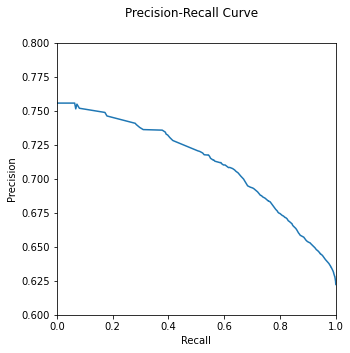

In [0]:
# Plot precision-recall curve using Pandas and matplotlib
# Clearer plot than using display()
pr_data = log_reg_model.summary.pr.toPandas()

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.plot(pr_data["recall"], pr_data["precision"])
plt.ylabel('Precision')
plt.xlabel('Recall')
fig.suptitle('Precision-Recall Curve')
plt.ylim(0.6,0.8)
plt.xlim(0,1)
# Display matplotlib figure in notebook
display(fig)

**F-Measure** In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score. The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. See [Wikipedia article on F-Measure](https://en.wikipedia.org/wiki/F1_score)

$$F1 = \frac {2}{\frac {1}{recall}+\frac {1}{precision}}$$

In [0]:
# Examine how the F-Measure changes by with different values of the threshold
log_reg_model.summary.fMeasureByThreshold.show(5)

+------------------+-------------------+
 threshold| F-Measure|
+------------------+-------------------+
 0.742200181391449|0.11792998196364984|
0.7318819656336697| 0.1244076374511157|
0.7305984841134536|0.13151387489696859|
0.7290898796941576| 0.1458531503374553|
0.7279754995920253| 0.2800163132137031|
+------------------+-------------------+
only showing top 5 rows

In [0]:
# The plot of F-Measure vs threshold
# Shows that a threshold of 0.5 is reasonable
display(log_reg_model.summary.fMeasureByThreshold)

threshold,F-Measure
0.742200181391449,0.11792998196364984
0.7318819656336697,0.1244076374511157
0.7305984841134536,0.13151387489696859
0.7290898796941576,0.1458531503374553
0.7279754995920253,0.2800163132137031
0.7173048044431949,0.28067172087715003
0.7144201499217919,0.2896875126328981
0.7132691577678626,0.4074626322871587
0.7121432250982835,0.4109569187289394
0.7061342859415707,0.4233795965087995


**ROC Curve**

In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
See [ROC Curve Article on Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [0]:
# and plot the ROC curve
log_reg_model.summary.roc.show(5)

+--------------------+-------------------+
 FPR| TPR|
+--------------------+-------------------+
 0.0| 0.0|
 0.03404958677685951|0.06395465489566614|
 0.03694214876033058|0.06781701444622792|
 0.03851239669421488|0.07203049759229535|
0.043884297520661156|0.08075842696629214|
+--------------------+-------------------+
only showing top 5 rows

In [0]:
# Prepare a DataFrame with ROC curve and reference Non-discrimination line
roc = log_reg_model.summary.roc
roc = roc.withColumn("Non-discrimination", roc.FPR).filter(roc.FPR < 1.0)

In [0]:
display(roc)

FPR,TPR,Non-discrimination
0.0,0.0,0.0
0.03404958677685951,0.06395465489566614,0.03404958677685951
0.03694214876033058,0.06781701444622792,0.03694214876033058
0.03851239669421488,0.07203049759229535,0.03851239669421488
0.043884297520661156,0.08075842696629214,0.043884297520661156
0.09512396694214877,0.1722010433386838,0.09512396694214877
0.09545454545454546,0.17270264847512037,0.09545454545454546
0.10066115702479339,0.17972512038523275,0.10066115702479339
0.16190082644628098,0.2809991974317817,0.16190082644628098
0.16462809917355373,0.2844602728731942,0.16462809917355373


In [0]:
# We can also query the model performance, in this case, the area under the ROC curve  (often referred to as AUC)
# However, it has some limitations - see Wikipedia article on ROC 

log_reg_model.summary.areaUnderROC

Out[31]: 0.6296322011428304

#### Evaluate model performance on the test set

We have been assessing the model performance on the train DataFrame.  We really want to assess it on the test DataFrame.

**Method 1:** Use the `evaluate` method of the `LogisticRegressionModel` class. The result is an instance of the [BinaryLogisticRegressionSummary](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.BinaryLogisticRegressionSummary) class

In [0]:
test_summary = log_reg_model.evaluate(test)

# The result is an instance of the `BinaryLogisticRegressionSummary` class
type(test_summary)

Out[32]: pyspark.ml.classification.BinaryLogisticRegressionSummary

In [0]:
# It has attributes similar to those of the `BinaryLogisticRegressionTrainingSummary` class we just examined. 
test_summary.areaUnderROC

Out[33]: 0.6216338579736557

In [0]:
# Prepare a DataFrame with ROC curve and reference Non-discrimination line
roc2 = test_summary.roc
roc2 = roc2.withColumn("Non-discrimination", roc2.FPR).filter(roc2.FPR < 1.0)

In [0]:
display(roc2)

FPR,TPR,Non-discrimination
0.0,0.0,0.0
0.031179985063480208,0.06379453189726594,0.031179985063480208
0.03472740851381628,0.06781867676648123,0.03472740851381628
0.038461538461538464,0.07219789324180377,0.038461538461538464
0.04798356982823002,0.07953603976801989,0.04798356982823002
0.10231516056758776,0.17244644336607884,0.10231516056758776
0.10250186706497386,0.17327494378032904,0.10250186706497386
0.10866318147871545,0.18025801870043792,0.10866318147871545
0.1713965646004481,0.2781394247839981,0.1713965646004481
0.1734503360716953,0.28180849804710617,0.1734503360716953


**Method 2:** Use the `evaluate` method of the [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html) class. 

This approach can be used in a pipeline and for hyperparameter search.

**Note:** The resulting DataFrame includes three types of predictions.  
- The `rawPrediction` is a vector of log-odds
- `probability` is a vector or  probabilities 
$$Probability = logit(rawPrediction) = \frac {1}{1+e^\text{-raw}}$$
- `prediction` is the predicted class based on the probability vector

In [0]:
# Generate predictions on the test DataFrame:
test_with_prediction = log_reg_model.transform(test)

# The resulting dataframe includes rawPrediction, probability, and prediction
test_with_prediction.head(2)

Out[36]: [Row(reviewed=0, vehicle_year=2002, vehicle_color_cd=SparseVector(9, {0: 1.0}), star_rating=2.0, high_rating=0.0, features=SparseVector(11, {1: 2002.0, 2: 1.0}), rawPrediction=DenseVector([0.0385, -0.0385]), probability=DenseVector([0.5096, 0.4904]), prediction=0.0),
 Row(reviewed=0, vehicle_year=2002, vehicle_color_cd=SparseVector(9, {0: 1.0}), star_rating=2.0, high_rating=0.0, features=SparseVector(11, {1: 2002.0, 2: 1.0}), rawPrediction=DenseVector([0.0385, -0.0385]), probability=DenseVector([0.5096, 0.4904]), prediction=0.0)]

In [0]:
# Can view a few of the predictions in tabular format
test_with_prediction.sample(0.001) \
  .drop("features", "rawPrediction", "vehicle_color_cd")\
  .withColumnRenamed("vehicle_year", "year")\
  .withColumnRenamed("star_rating", "star")\
  .withColumnRenamed("high_rating", "high")\
  .show(10, False)

+--------+----+----+----+----------------------------------------+----------+
reviewed|year|star|high|probability |prediction|
+--------+----+----+----+----------------------------------------+----------+
0 |2003|5.0 |1.0 |[0.4913531862397695,0.5086468137602305] |1.0 |
0 |2005|5.0 |1.0 |[0.45165221135407935,0.5483477886459207]|1.0 |
0 |2005|4.0 |0.0 |[0.4681761430500675,0.5318238569499325] |1.0 |
0 |2006|1.0 |0.0 |[0.4847726600627538,0.5152273399372462] |1.0 |
0 |2007|5.0 |1.0 |[0.41901162001280307,0.5809883799871969]|1.0 |
0 |2007|2.0 |0.0 |[0.4665528866871312,0.5334471133128689] |1.0 |
0 |2012|4.0 |0.0 |[0.3699922464553561,0.6300077535446439] |1.0 |
0 |2013|5.0 |1.0 |[0.3175196118236876,0.6824803881763124] |1.0 |
0 |2014|5.0 |1.0 |[0.30190252205644963,0.6980974779435504]|1.0 |
0 |2014|4.0 |0.0 |[0.3372198335201457,0.6627801664798543] |1.0 |
+--------+----+----+----+----------------------------------------+----------+
only showing top 10 rows

In [0]:
# Create an instance of `BinaryClassificationEvaluator` class
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="high_rating", metricName="areaUnderROC")

# Look at it parameters
print(evaluator.explainParams())

labelCol: label column name. (default: label, current: high_rating)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC, current: areaUnderROC)
numBins: Number of bins to down-sample the curves (ROC curve, PR curve) in area computation. If 0, no down-sampling will occur. Must be >= 0. (default: 1000)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction, current: rawPrediction)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

In [0]:
# Look the default metric (i.e. areaUnderROC)
evaluator.evaluate(test_with_prediction)

Out[39]: 0.6216338579736557

In [0]:
# Evaluate using another metric
evaluator.setMetricName("areaUnderPR").evaluate(test_with_prediction)

Out[40]: 0.6960456346450599

#### Score out a new dataset

Scoring is widely used in machine learning to mean the process of generating new values, given a model and some new input. The generic term "score" is used, rather than "prediction," because the scoring process can generate so many different types of values:
- A list of recommended items and a similarity score.
- Numeric values, for time series models and regression models.
- A probability value, indicating the likelihood that a new input belongs to some existing category.
- The name of a category or cluster to which a new item is most similar.
- A predicted class or outcome, for classification models. (Source: Microsoft)


There are two ways to score out a new dataset.

**Method1:** The `evaluate` method

The more expensive way is to use the `evaluate` method of the `LogisticRegressionModel` class.  The `predictions` attribute of the resulting `BinaryLogisticRegressionSummary` instance contains the scored DataFrame. 

Note: This is more expensive because the `evaluate` method computes all the evaluation metrics in addition to scoring out the DataFrame. See the API documentation to see all the evaluation metrics available.

In [0]:
# Method1: The `evaluate` method
test_with_evaluation = log_reg_model.evaluate(test)
test_with_evaluation.predictions.printSchema()

root
-- reviewed: integer (nullable = false)
-- vehicle_year: integer (nullable = true)
-- vehicle_color_cd: vector (nullable = true)
-- star_rating: double (nullable = true)
-- high_rating: double (nullable = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
# Show some rows for rides that did not have a high rating
# Dropped columns to make printing easier
test_with_evaluation.predictions\
  .sample(0.002)\
  .filter(test_with_evaluation.predictions.high_rating == 0)\
  .select("vehicle_year","high_rating","probability","prediction").show(5, False)

# Show some rows for rides that had a high rating
test_with_evaluation.predictions\
  .sample(0.001)\
  .filter(test_with_evaluation.predictions.high_rating == 1)\
  .select("vehicle_year","high_rating","probability","prediction").show(5, False)

+------------+-----------+----------------------------------------+----------+
vehicle_year|high_rating|probability |prediction|
+------------+-----------+----------------------------------------+----------+
2002 |0.0 |[0.5545872429874417,0.44541275701255834]|0.0 |
2003 |0.0 |[0.7078936105438364,0.29210638945616363]|0.0 |
2004 |0.0 |[0.5182673743610915,0.4817326256389085] |0.0 |
2006 |0.0 |[0.43362958054088946,0.5663704194591106]|1.0 |
2007 |0.0 |[0.41901162001280307,0.5809883799871969]|1.0 |
+------------+-----------+----------------------------------------+----------+
only showing top 5 rows

+------------+-----------+----------------------------------------+----------+
vehicle_year|high_rating|probability |prediction|
+------------+-----------+----------------------------------------+----------+
2004 |1.0 |[0.47311319689618436,0.5268868031038156]|1.0 |
2006 |1.0 |[0.43689536061902556,0.5631046393809744]|1.0 |
2007 |1.0 |[0.4665528866871312,0.5334471133128689] |1.0 |
2007 |1.0 |[0.45835958956870215,0.5416404104312978]|1.0 |
2012 |1.0 |[0.3680679622353102,0.6319320377646898] |1.0 |
+------------+-----------+----------------------------------------+----------+
only showing top 5 rows

**Method 2:** The `transform` method

The more direct and efficient way is to use the `transform` method of the `LogisticRegressionModel` class.

In [0]:
# Method 2: The `transform` method

test_with_prediction = log_reg_model.transform(test)
test_with_prediction.printSchema()

for item in test_with_prediction.head(2):
    print(item)

root
-- reviewed: integer (nullable = false)
-- vehicle_year: integer (nullable = true)
-- vehicle_color_cd: vector (nullable = true)
-- star_rating: double (nullable = true)
-- high_rating: double (nullable = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

Row(reviewed=0, vehicle_year=2002, vehicle_color_cd=SparseVector(9, {0: 1.0}), star_rating=2.0, high_rating=0.0, features=SparseVector(11, {1: 2002.0, 2: 1.0}), rawPrediction=DenseVector([0.0385, -0.0385]), probability=DenseVector([0.5096, 0.4904]), prediction=0.0)
Row(reviewed=0, vehicle_year=2002, vehicle_color_cd=SparseVector(9, {0: 1.0}), star_rating=2.0, high_rating=0.0, features=SparseVector(11, {1: 2002.0, 2: 1.0}), rawPrediction=DenseVector([0.0385, -0.0385]), probability=DenseVector([0.5096, 0.4904]), prediction=0.0)

In [0]:
# Show some rows for rides that did not have a high rating
# Dropped a columns to make printing easier

# Show some rows for rides that did not have a high rating
# Dropped columns to make printing easier
test_with_prediction\
  .sample(0.001)\
  .filter(test_with_evaluation.predictions.high_rating == 0)\
  .select("vehicle_year","high_rating","probability","prediction").show(5, False)

# Show some rows for rides that had a high rating
test_with_prediction\
  .sample(0.001)\
  .filter(test_with_evaluation.predictions.high_rating == 1)\
  .select("vehicle_year","high_rating","probability","prediction").show(5, False)

# test_with_prediction.filter(test_with_prediction.high_rating == 1).drop("features").show(5)

+------------+-----------+----------------------------------------+----------+
vehicle_year|high_rating|probability |prediction|
+------------+-----------+----------------------------------------+----------+
2005 |0.0 |[0.5030330000608207,0.49696699993917925]|0.0 |
2008 |0.0 |[0.40133817911382214,0.5986618208861778]|1.0 |
2009 |0.0 |[0.430426991765376,0.569573008234624] |1.0 |
2010 |0.0 |[0.41261401249974267,0.5873859875002574]|1.0 |
2013 |0.0 |[0.3175196118236876,0.6824803881763124] |1.0 |
+------------+-----------+----------------------------------------+----------+
only showing top 5 rows

+------------+-----------+----------------------------------------+----------+
vehicle_year|high_rating|probability |prediction|
+------------+-----------+----------------------------------------+----------+
2002 |1.0 |[0.5494264093927131,0.45057359060728686]|0.0 |
2011 |1.0 |[0.392141252957305,0.607858747042695] |1.0 |
2013 |1.0 |[0.3175196118236876,0.6824803881763124] |1.0 |
2014 |1.0 |[0.30190252205644963,0.6980974779435504]|1.0 |
2014 |1.0 |[0.3413010953485008,0.6586989046514993] |1.0 |
+------------+-----------+----------------------------------------+----------+
only showing top 5 rows

###Hands On

![Hands-on](https://cis442f-open-data.s3.amazonaws.com/pictures/hands.png "Hands-on")


#### Exercises

(1) Experiment with different sets of features.

(2) Plot the train and test ROC curves in the same figure?

(3) Use multinomial logistic regression to predict the original star rating.

(4) Experiment with at least one other classification algorithm.


#### References

[Classification and regression](http://spark.apache.org/docs/latest/ml-classification-regression.html)

[pyspark MLlib classification](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification)